## Setup Steps

1. Open terminal
2. Run `uv sync`
3. Ensure venv Python is selected as kernel in notebook
4. Run `uipath auth --staging` and authenticate to uipathlabs



In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

print(os.getenv("UIPATH_ACCESS_TOKEN")[:10])

eyJhbGciOi


Do you see the first 10 characters of an access token? e.g. `eyJhbGciOi`

### Yay!

If you don't see your access token, make sure you have a `.env` file in your project root directory. Try running the `uipath auth` terminal command again or ask for assistance.

# Exercise 1

## What we're building

In this exercise, we'll use a simple tool-calling agent abstraction from Lanchain. The definition of this agent is a text-based version of a ReAct-style agent - very similar to what we prescribe through Agent Builder with a graphical or form-based approach.

<div style="text-align:center">
<img src="assets/create_agent.png" width="500">
</div>

The agent calls tools in a loop until it determines the task is complete.

We'll first define the agent components: 
* model
* system prompt 
* user prompt 
* tools

Then we'll show how we can add some code around the model and tools to provide structured inputs and outputs. 

To support structured inputs and outputs, we’ll use a graph builder from LangGraph. We use this approach because the UiPath SDK is built to recognize and connect to the graph.

This matters for deployment: using this pattern allows UiPath to automatically generate a descriptor file that clearly defines the inputs and outputs. As a result, those inputs and outputs are correctly exposed and configurable in Orchestrator (and therefore also in Maestro).

## Define Agent Components

### 1. Model

A great part of our interoperability story is how the UiPath Python SDK provides simple libraries to use LLMs connected through the AI Trust Layer in a Langchain agent.

In [2]:
from uipath_langchain.chat.models import UiPathChat

llm = UiPathChat(
    model="gpt-4o-2024-11-20",
    temperature=0,
    max_tokens=4000,
    timeout=30,
    max_retries=2,
    # other params...
)

response = llm.invoke("What is the capital of the moon?")

print(response.content)

Response content: {"id":"chatcmpl-CxM1YzcJXGYwOSaITrISvT4MNTLfx","model":"gpt-4o-2024-11-20","object":"chat.completion","choices":[{"finish_reason":"stop","index":0,"message":{"content":"The Moon does not have a capital, as it is not a country or governed by any political entity. It is a natural satellite of Earth. However, humans have explored the Moon, and notable locations include the Apollo landing sites, such as Tranquility Base, where Apollo 11 landed in 1969.","role":"assistant"}}],"created":1768262048,"usage":{"completion_tokens":64,"prompt_tokens":15,"total_tokens":79,"cache_read_input_tokens":0}}

The Moon does not have a capital, as it is not a country or governed by any political entity. It is a natural satellite of Earth. However, humans have explored the Moon, and notable locations include the Apollo landing sites, such as Tranquility Base, where Apollo 11 landed in 1969.


# What Happened?

<div style="text-align:center">
<img src="assets/LLM_Calls.png" width="800">
</div>

### 2. System Prompt

In [3]:
system_prompt = """You are a helpful assistant that can answer questions and help with tasks. 
Use your get_weather tool to find the weather for a given location.
"""

### 3. User Prompt

In [4]:
user_prompt = """What is the weather in London?"""

### 4. Tools

We'll define mock tools first. 

Tools are just functions either executed locally, or remotely (e.g. MCP tools run on a remote server). 

We'll implement two flavors of remote tools later to show how this agent can use UiPath resources.

In [5]:
from langchain.tools import tool #We need to import the tool decorator from langchain


@tool
def get_weather(city: str) -> str:
    """Get the weather for a given location."""
    return f" It is sunny and 75 in {city}."

### 5. Create the Agent

In [6]:
from langchain.agents import create_agent
from langchain.messages import HumanMessage


agent = create_agent(
    model=llm,
    tools=[get_weather],
    system_prompt=system_prompt
    )

messages = [HumanMessage(content=user_prompt)]

### 6. Run the agent

In [7]:
response = agent.invoke({"messages": messages})

print(response["messages"][-1].content)

Response content: {"id":"chatcmpl-CxM1acJryms1LfHqEdMEr05xlt9pQ","model":"gpt-4o-2024-11-20","object":"chat.completion","choices":[{"finish_reason":"tool_calls","index":0,"message":{"role":"assistant","tool_calls":[{"id":"call_O6UuKkqfNYRH1zUP5FKtLItm","name":"get_weather","arguments":{"city":"London"}}]}}],"created":1768262050,"usage":{"completion_tokens":15,"prompt_tokens":81,"total_tokens":96,"cache_read_input_tokens":0}}

Response content: {"id":"chatcmpl-CxM1b4LwJ32s0M06t1holU42AzgaF","model":"gpt-4o-2024-11-20","object":"chat.completion","choices":[{"finish_reason":"stop","index":0,"message":{"content":"The weather in London is sunny with a temperature of 75\u00B0F.","role":"assistant"}}],"created":1768262051,"usage":{"completion_tokens":16,"prompt_tokens":113,"total_tokens":129,"cache_read_input_tokens":0}}

The weather in London is sunny with a temperature of 75°F.


### That was cool

...but you might have noticed we received JSON objects in the response as the agent was working and then only printed the final output. 

We can run the agent with streaming and see the intermediate events that occur (e.g. tool calls) - think of this like a very basic trace of the agent execution. The code below isn't doing anything fancy - just parsing the output JSON objects and adding some formatting.

In [8]:
from utils import AgentStreamHandler


agent_with_streaming = AgentStreamHandler()

agent_with_streaming.stream(agent, messages)


STEP 1  |  time=2026-01-12T17:54:11
State keys: ['messages']
--------------------------------------------------------------------------------
Latest message role: human
Latest message class: HumanMessage
[OTHER MESSAGE]
  content:
    What is the weather in London?
Response content: {"id":"chatcmpl-CxM1busCI2Yw9NeahPhYB2MeJYP9j","model":"gpt-4o-2024-11-20","object":"chat.completion","choices":[{"finish_reason":"tool_calls","index":0,"message":{"role":"assistant","tool_calls":[{"id":"call_ImHDwc1r0lkP8MbreeHivgSb","name":"get_weather","arguments":{"city":"London"}}]}}],"created":1768262051,"usage":{"completion_tokens":15,"prompt_tokens":81,"total_tokens":96,"cache_read_input_tokens":0}}


STEP 2  |  time=2026-01-12T17:54:12
State keys: ['messages']
--------------------------------------------------------------------------------
Latest message role: ai
Latest message class: AIMessage
[AI → TOOL CALL]
  Tool call 0:
    name: get_weather
    args: {'city': 'London'}

STEP 3  |  time=2026

# CONGRATULATIONS

Exercise 1 is complete. 

## What we built:

* A ReAct-style (tool-calling) agent
* A simulated get_weather tool
* Streamed the agent execution trace

Now we'll update the agent to use more realistic tools!

# Exercise 2

## Add UiPath Context Grounding

In this exercise, we'll add UiPath Context Grounding as a tool to the agent we built previously.

The `ContextGroundingRetriever` is a class included in the UiPath Langchain SDK that implements a search on the index you specify. 

The index must be created and available in Orchestrator. 

For this lab, we'll be using an index named 'SKOFY26PolicyDocument' - this is in staging.uipath.com/uipathlabs in the AMER Presales folder.

If you're curious what the `ContextGroundingRetriever` class implements in code - you can see the source here: https://github.com/UiPath/uipath-langchain-python/blob/main/src/uipath_langchain/retrievers/context_grounding_retriever.py

You'll see that it implements the `search` method from the uipath-python SDK on the Context Grounding service (i.e. a Python client that uses the API to invoke actions with Context Grounding)

https://uipath.github.io/uipath-python/core/context_grounding/#uipath.platform.context_grounding._context_grounding_service.ContextGroundingService.search

The `search` method implements semantic search on the index.

Finally, we'll wrap the `ContextGroundingRetriever` with a class from Langchain that turns the retriever into a tool that is understood by a Langchain agent.

<div style="text-align:center">
<img src="assets/ContextGroundingRetriever.png" width="800">
</div>

### 1. Create the ContextGroundingRetriever

In [9]:
import pprint
from uipath_langchain.retrievers import ContextGroundingRetriever

retriever = ContextGroundingRetriever(
    index_name = "KYC_DocVal_AgentCG",
    folder_path = "AMER Presales/FINS"
    )
pprint.pprint(retriever.invoke("What is the guideline for matching business names?"), indent=2)

[ Document(metadata={'source': 'KYC_DocValidation_DataMatchingSOP.docx', 'page_number': '1'}, page_content='Simple Guide to Semantic Similarity for Matching Business Names\nWhat is Semantic Similarity?\n\uf0b7Semantic similarity  refers to measuring how similar two pieces of data \nare in meaning, not just in words. It’s about understanding the concepts \nbehind the text, even if the exact words are different.\nFor example:\n\uf0b7"Tech Innovations LLC" and "Innovative Technology Ltd." are not the same \nwords, but their meaning is very similar because both refer to a tech \ncompany.\nHow to Determine if Two Business Names Are the Same\nHere’s a simplified process for an AI to decide whether two business names are \nthe same:\n1.Normalize the Text :\noRemove unnecessary words like "Inc.", "LLC", "Ltd.", "Co.", and \ncommon connectors like "and", "of".\noConvert everything to lowercase to ignore case differences.\nExample:\no"Tech Innovations LLC"  "tech innovations" →\no"Innovative Tec

### 2. Create the retriever tool

In [10]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "KYC_DocVal_AgentCG",
   """
   Use this tool to search the company guidelines on validating that business names match, license type validity, and overall data matching guidelines for 
   a submitted business name or license type.
   """
)

### 3. Add the tool to the agent

In [11]:
agent_with_cg = create_agent(
    model = llm,
    tools = [retriever_tool],
    system_prompt = """
    You are a KYC Document Validator agent. Use your KYC_DocVal_AgentCG tool to search for guidelines to help respond to requests to match
    business names.
    """
)

### 4. Run the agent

In [12]:
agent_cg_stream = AgentStreamHandler()

user_prompt = """Do these two business names match? 
        Business name 1: Waters Corp. 
        Business name 2: Waters Corporation Inc.
        """

messages = [HumanMessage(content=user_prompt)]

agent_cg_stream.stream(
    agent_with_cg, 
    messages=messages)


STEP 1  |  time=2026-01-12T17:54:15
State keys: ['messages']
--------------------------------------------------------------------------------
Latest message role: human
Latest message class: HumanMessage
[OTHER MESSAGE]
  content:
    Do these two business names match? 
        Business name 1: Waters Corp. 
        Business name 2: Waters Corporation Inc.
        
Response content: {"id":"chatcmpl-CxM1g5WVqALmnUaaSrBKQjQJOKudi","model":"gpt-4o-2024-11-20","object":"chat.completion","choices":[{"finish_reason":"tool_calls","index":0,"message":{"role":"assistant","tool_calls":[{"id":"call_80RhSPokBNSobpgMto6h7bYJ","name":"KYC_DocVal_AgentCG","arguments":{"query":"guidelines for matching business names"}}]}}],"created":1768262056,"usage":{"completion_tokens":26,"prompt_tokens":155,"total_tokens":181,"cache_read_input_tokens":0}}


STEP 2  |  time=2026-01-12T17:54:16
State keys: ['messages']
--------------------------------------------------------------------------------
Latest message r

# WOW

You now have a Langchain agent that calls UiPath Context Grounding as a tool!

This is a great pattern for demos, because the agent code is simple, you can customize by swapping out the index names, and highlight a realistic example in Maestro (we'll cover deployment soon!)

# Exercise 3

## Structured inputs and outputs

Preparing for deployment

### 1. Define Input and Output Structure

In [13]:
from pydantic import BaseModel

class GraphInput(BaseModel):
    company_name_1: str
    compane_name_2: str

class GraphOutput(BaseModel):
    match_score: int
    explanation: str

### 2. Wrap the Agent in a function

This allows us to add the agent to graph so it can take the inputs and produce the the structured output.

In [14]:
import json

agent_with_cg = create_agent(
    model = llm,
    tools = [retriever_tool],
    system_prompt = """
    You are a KYC Document Validator agent. Use your KYC_DocVal_AgentCG tool to search for guidelines to help respond to requests to match
    business names. Respond with a match_score and an explanation.
    """,
    response_format=GraphOutput
)

async def agent(state: GraphInput) -> GraphOutput:
    user_prompt = f"""Do these two business names match? 
        Business name 1: {state.company_name_1} 
        Business name 2: {state.compane_name_2}
        """
    
    messages = [HumanMessage(content=user_prompt)]



    result = await agent_with_cg.ainvoke({"messages": messages})
    output = json.loads(result["messages"][-1].content)
    return GraphOutput(match_score = output["match_score"], explanation=output["explanation"])


# Create a GraphInput instance - these are our input variables
input_state = GraphInput(
    company_name_1="Acme Corporation",
    compane_name_2="Acme Corp"
)

# Call the async function with await
result = await agent(input_state)
print(result)

match_score=90 explanation="The names 'Acme Corporation' and 'Acme Corp' are semantically similar, as 'Corp' is a common abbreviation for 'Corporation'. The core meaning and identity of the names align, indicating they likely refer to the same entity."


### 3. Build the Graph

We use a LangGraph graph builder to create a workflow of sorts - the UiPath SDK understands the graph structure, so that when we pack the agent with the SDK, it will extract the entry points (inputs and outputs) and render them in Orchestrator as part of the deployed .nupkg.

/tmp/ipykernel_61255/1894060881.py:4: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(GraphInput, output=GraphOutput)


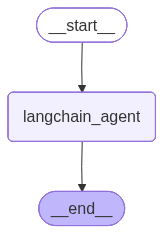

In [15]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(GraphInput, output=GraphOutput)
builder.add_node("langchain_agent", agent)

builder.add_edge(START, "langchain_agent")
builder.add_edge("langchain_agent", END)

# Compile the graph
graph = builder.compile()


# This just displays the graph we built - notice it's a wrapper around the langchain agent
display(Image(graph.get_graph().draw_mermaid_png()))


### Why does this look so simple?

The langchain_agent node is a single node that represents the agent we built above. Remember, the graph's purpose is just to provide the workflow that allows the UiPath SDK to capture input and output structure for packaging. 

What's really constructed in this graph looks like below - the middle node is a tool-calling agent, as described above.

<div style="text-align:center">
<img src="assets/full_agent.png" width="900">
</div>

# Run the Graph

In [17]:
await graph.ainvoke(input_state)

{'match_score': 90,
 'explanation': "The names 'Acme Corporation' and 'Acme Corp' are semantically similar, as 'Corp' is a common abbreviation for 'Corporation'. The core meaning and identity of the business are preserved, indicating a high likelihood that they refer to the same entity."}

# Putting it all together

### Instructions to deploy to Automation Cloud

#### 1. Open a new terminal session
#### 2. Go to a directory where you want to store the project (e.g. `cd coded-agents-projects` or make a new folder `mkdir coded-agents-projects`)
#### 3. Initialize a new uv project 
```bash
uv init . --python 3.12
```

#### 4. Initialize a virtual environment 
```bash
uv venv
```
#### 5. Activate the virtual environment 
Mac (bash or zsh)
```bash
source .venv\bin\activate
``` 
Windows (Powershell or CMD) 
```bash
.venv/Scripts/activate
```
#### 6. Add `uipath-langchain`

```bash
uv add uipath-langchain
```

#### 7. Create a new agent

```bash
uipath new agent-with-cg-[your_initials]
```

#### 8. Open the folder you created in a new Cursor window

#### 9. Copy and paste the full code below into `main.py`

#### 10. Authenticate (with staging flag if connecting to staging)

```bash
uipath auth --staging
```

#### 11. Initialize the agent

```bash
uipath init
```

#### 12. Pack the project

```bash
uipath pack
```

#### 13. Publish the project

```bash
uipath publish
```


## Full Code

Do not run this code here - just use it for reference to copy into your new project per the above instructions

In [ ]:
from langgraph.graph import END, START, StateGraph
from langchain_core.tools.retriever import create_retriever_tool
from uipath_langchain.retrievers import ContextGroundingRetriever
from langchain.agents import create_agent
from pydantic import BaseModel
from uipath_langchain.chat.models import UiPathChat
import json

#Configure LLM to use UiPath Trust Layer
llm = UiPathChat(
    model="gpt-4o-2024-11-20",
    temperature=0,
    max_tokens=4000,
    timeout=30,
    max_retries=2,
    # other params...
)

#Define Input and Output Structure
class GraphInput(BaseModel):
    company_name_1: str
    compane_name_2: str

class GraphOutput(BaseModel):
    match_score: int
    explanation: str

#Create Context Grounding retriever tool

retriever = ContextGroundingRetriever(
    index_name = "KYC_DocVal_AgentCG",
    folder_path = "AMER Presales/FINS"
    )
retriever_tool = create_retriever_tool(
    retriever,
    "KYC_DocVal_AgentCG",
   """
   Use this tool to search the company guidelines on validating that business names match, license type validity, and overall data matching guidelines for 
   a submitted business name or license type.
   """
)

#Assemble the Agent with a system prompt
agent_with_cg = create_agent(
    model = llm,
    tools = [retriever_tool],
    system_prompt = """
    You are a KYC Document Validator agent. Use your KYC_DocVal_AgentCG tool to search for guidelines to help respond to requests to match
    business names. Respond with a match_score and an explanation.
    """,
    response_format=GraphOutput
)

#Wrap the agent and the user prompt template in a function so we can add it to a graph node
async def agent(state: GraphInput) -> GraphOutput:
    user_prompt = f"""Do these two business names match? 
        Business name 1: {state.company_name_1} 
        Business name 2: {state.compane_name_2}
        """    
    messages = [HumanMessage(content=user_prompt)]

    result = await agent_with_cg.ainvoke({"messages": messages})
    output = json.loads(result["messages"][-1].content)
    return GraphOutput(match_score = output["match_score"], explanation=output["explanation"])


#Assemble the langGraph graph that calls the agent
builder = StateGraph(GraphInput, output=GraphOutput)
builder.add_node("langchain_agent", agent)

builder.add_edge(START, "langchain_agent")
builder.add_edge("langchain_agent", END)

# Compile the graph
graph = builder.compile()